## 지수 생성용 전처리

In [146]:
# 그리드 별 개수 구해서 추가하는 함수 정의
def grid_count(df, name):
    df = df.groupby('id').count().reset_index()
    df = df[['id','SIG_KOR_NM']]
    df.columns = ['id', name]
    return df

# 그리드 별 평균 구해서 추가하는 함수 정의
def grid_mean(df, name):
    df = df.groupby('id').mean().reset_index()
    df = df[['id','SIG_KOR_NM']]
    df.columns = ['id', name]
    return df

### 안전 지수

In [147]:
# 그리드 별 가로등 개수 구하기
df_light = grid_count(street_lights, '가로등')

# 그리드 별 파출소 개수 구하기
df_police_office = grid_count(police_office, '파출소')

# 그리드 별 cctv 개수 구하기
df_cctv = cctv.groupby('id').sum().reset_index()[['id','카메라대수']]
df_cctv['카메라대수'] = df_cctv['카메라대수']*9

In [148]:
from functools import reduce
dfs = [geo, df_light, df_police_office, df_cctv]
df_merge = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), dfs)
df_merge = df_merge.drop(['left','top','right','bottom','SIG_CD','SIG_KOR_NM'],axis=1)
safety = df_merge

### 교통 지수

역, 터미널과의 거리의 경우에는,  
- 오송역  
- 반석역  
- 조치원역  
- 세종고속시외버스터미널  
- 조치원공영버스터미널   
을 고려함

제외한 역  
- 전의역, 부강역도 하루에 몇 번 정차하지만 이용하기 불편한 횟수  
- 전동역, 서창역, 내판역, 매포역, 소정리역은 모든 여객열차가 정차하지 않음  
- 청주역: 충북이기도 하고, 사람들이 엄청 다니는 역도 아님.  

In [149]:
# 그리드 별 버스 별 배차 개수 구하기
df_bus = bus[['id','BRT','광역버스','지선버스','간선버스','마을버스']]
df_bus=df_bus.groupby(["id"])['BRT','광역버스','지선버스','간선버스','마을버스'].sum().reset_index()

#  그리드 별 중앙 좌표와 가까운 역, 터미널과의 거리 구하기
station = pd.read_csv('sejong_stations.csv')
station_geo= gpd.GeoDataFrame(station, geometry = gpd.points_from_xy(station.경도, station.위도))
station_geo.crs = geo.crs

distance_station = []

for i in geo['geometry']:
    temp = []
    for j in station_geo['geometry']:
        temp.append(i.distance(j))
    
    distance_station.append(min(temp)) 
    
station_dist = geo.copy()
station_dist["역 터미널"] = distance_station
station_dist = station_dist[['id', '역 터미널']]

In [150]:
from functools import reduce
dfs = [geo, df_bus, station_dist]
df_merge = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), dfs)
df_merge = df_merge.drop(['left','top','right','bottom','SIG_CD','SIG_KOR_NM'],axis=1)

In [151]:
# 거리가 멀수록 페널티를 주기 위해 Hyperbolic Tangent 도함수에 넣어준 뒤, 정규화를 진행합니다
def diff_tanh(x):
    return 4/(np.exp(2*x)+2+np.exp(-2*x))

dfdf = diff_tanh(df_merge['역 터미널'])

dfdf = pd.DataFrame(dfdf, columns=['역 터미널'])
df_merge['역 터미널']=dfdf['역 터미널']
transport=df_merge

### 생활 편의 지수

In [152]:
# 그리드 별 병원 개수 구하기
df_hospital = grid_count(hospital, '병원')

# 그리드 별 은행 개수 구하기
df_banks = grid_count(banks, '은행')

# 그리드 별 학교 개수 구하기
df_schools = school.groupby(['id','학교구분']).count().unstack()
df_schools = df_schools[df_schools.columns[0:3]].reset_index()
df_schools.columns = ['id','고등학교', '중학교', '초등학교']

# 그리드 별 공원 개수 구하기
df_parks = grid_count(parks, '공원')

# 그리드 별 학원 개수 구하기
df_academy = grid_count(academy, '학원')

# 그리드 별 편의점 개수 구하기
df_stores = grid_count(stores, '편의점')

# 그리드 별 마트 개수 구하기
df_mart = grid_count(mart, '마트')

# 그리드 별 약국 개수 구하기
df_pharmacy = grid_count(pharmacy, '약국')

# 그리드 별 중앙 좌표와 가까운 상권과의 거리 구하기
distance_store = []
for i in geo['geometry']:
    temp = []
    for j in store_cluster_geo['geometry']:
        temp.append(i.distance(j))
    
    distance_store.append(min(temp))
store_dist = geo.copy()
store_dist["상권"] = distance_store
store_dist = store_dist[['id', '상권']]


# 그리드 별 중앙 좌표와 가까운 학원가와의 거리 구하기
distance_academy = []
for i in geo['geometry']:
    temp = []
    for j in academy_cluster_geo['geometry']:
        temp.append(i.distance(j))
    
    distance_academy.append(min(temp)) 
academy_dist = geo.copy()
academy_dist["학원가"] = distance_academy
academy_dist = academy_dist[['id', '학원가']]

In [153]:
from functools import reduce
dfs = [geo, df_hospital, df_banks, df_schools, df_parks, df_academy, 
       df_stores, df_pharmacy, df_mart, store_dist, academy_dist]
df_merge = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), dfs)
df_merge = df_merge.drop(['left','top','right','bottom','SIG_CD','SIG_KOR_NM'],axis=1)

In [154]:
# 거리가 멀수록 페널티를 주기 위해 Hyperbolic Tangent 도함수에 넣어준 뒤, 정규화를 진행합니다
def diff_tanh(x):
    return 4/(np.exp(2*x)+2+np.exp(-2*x))

dfdf = diff_tanh(df_merge[['상권','학원가']])
df_merge[['상권','학원가']]=dfdf[['상권','학원가']]
life = df_merge

## PCA

- 여러 변수 간 존재하는 상관관계를 이용, 이를 대표하는 주성분을 추출하여 차원 축소하는 방법

- 각각 요소의 특징을 가장 잘 대변하는 단일 종합 지수 생성을 위해 PCA 선택

### 생활지수 

- 은행, 초등학교, 중학교, 고등학교, 공원, 학원, 편의점, 약국, 마트, 병원, 그리드별 가까운 상권/학원가와의 직선거리

In [155]:
# NA 값은 0개이기에, 0으로 입력해준다.
life['은행']=life['은행'].fillna(0)
life['고등학교']=life['고등학교'].fillna(0)
life['중학교']=life['중학교'].fillna(0)
life['초등학교']=life['초등학교'].fillna(0) 
life['공원']=life['공원'].fillna(0)
life['학원']=life['학원'].fillna(0)
life['편의점']=life['편의점'].fillna(0) 
life['약국']=life['약국'].fillna(0)
life['마트']=life['마트'].fillna(0)
life['병원']=life['병원'].fillna(0)

In [156]:
# PCA 후, plot_grid_map을 하기 위해 ID가 필요하므로 미리 추출한다.
id=life['id']

# PCA를 위해 x 설정.
x=life[['은행','고등학교','중학교','초등학교','공원','학원','편의점','약국','마트','상권','학원가']]

# PCA를 활용하여 지수를 만드는 것이기에, n_components 1로 고정.

pca= PCA(n_components = 1)
PC=pca.fit_transform(x)
result1 = pd.DataFrame(PC, columns=['PC1'])
result1['id']=id # pca결과에 id 데이터 추가.

# PCA PC1값에 minmax scaling을 해주었다. 
# 이유: 다중회귀분석 
min_max_scaler = MinMaxScaler(feature_range=(5,100))
x=result1['PC1']
x=x.to_numpy(dtype=float)
x=x.reshape(-1,1)
x1= min_max_scaler.fit_transform(x)
result1 = pd.DataFrame(x1, columns=['PC1'])
result1['id']=id # pca결과에 id 데이터 추가.
life_rate = result1

### 안전지수

- 가로등, 파출소, CCTV 대수

In [157]:
# NA 값은 0개이기에, 0으로 채워준다.
safety['가로등']=safety['가로등'].fillna(0)
safety['파출소']=safety['파출소'].fillna(0)
safety['카메라대수']=safety['카메라대수'].fillna(0)

In [158]:
# PCA 후, plot_grid_map을 하기 위해 ID가 필요하므로 미리 추출한다.
id=safety['id']
x=safety[['가로등','파출소','카메라대수']]

# PCA를 활용하여 지수를 만드는 것이기에, n_components 1로 고정.
pca= PCA(n_components = 1)
PC=pca.fit_transform(x)
result2 = pd.DataFrame(PC, columns=['PC1'])
result2['id']=id

# PCA PC1값에 minmax scaling을 해주었다. 
# 이유: 다중회귀분석 
x=result2['PC1']
x=x.to_numpy(dtype=float)
x=x.reshape(-1,1)
x1= min_max_scaler.fit_transform(x)
result2 = pd.DataFrame(x1, columns=['PC1'])
result2['id']=id 
safety_rate = result2

### 교통지수

- BRT, 광역, 지선, 간선, 마을버스 기준 그리드별 배차 횟수, 그리드별 중앙 좌표와 가까운 역, 터미널과의 거리

In [159]:
transport['BRT']=transport['BRT'].fillna(0) # NA값 0으로 대체
transport['광역버스']=transport['광역버스'].fillna(0)
transport['지선버스']=transport['지선버스'].fillna(0)
transport['간선버스']=transport['간선버스'].fillna(0)
transport['마을버스']=transport['마을버스'].fillna(0)

In [160]:
# PCA 후, plot_grid_map을 하기 위해 ID가 필요하므로 미리 추출한다.
id=transport['id']
x=transport[['BRT','광역버스','지선버스','간선버스','마을버스','역 터미널']]

# PCA를 활용하여 지수를 만드는 것이기에, n_components 1로 고정.
pca= PCA(n_components = 1)
PC=pca.fit_transform(x)
result3 = pd.DataFrame(PC, columns=['PC1'])
result3['id']=id

# PCA PC1값에 minmax scaling을 해주었다. 
# 이유: 다중회귀분석 
min_max_scaler = MinMaxScaler(feature_range=(5,100))
x=result3['PC1']
x=x.to_numpy(dtype=float)
x=x.reshape(-1,1)
x1= min_max_scaler.fit_transform(x)
result3 = pd.DataFrame(x1, columns=['PC1'])
result3['id']=id 
transport_rate = result3

### 생활 편의 지수

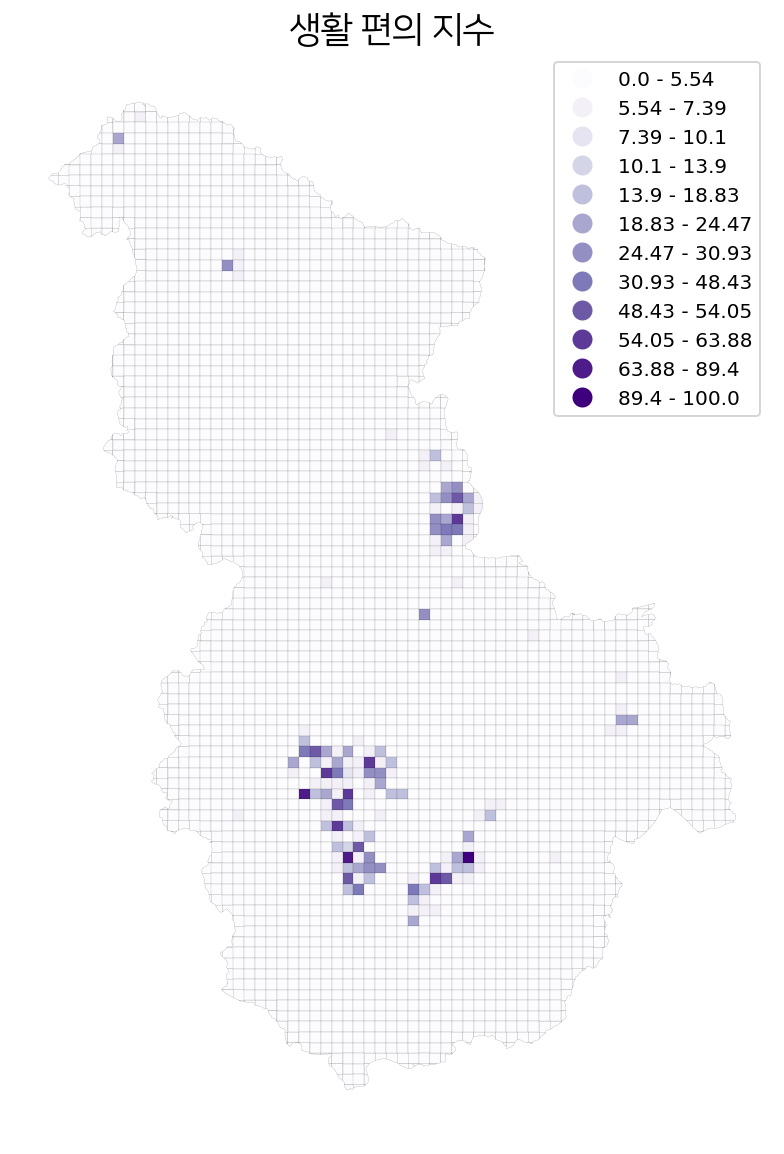

In [161]:
# PCA 결과를 바탕으로 geo(격자) 데이터와 합쳐준다.
pca = pd.merge(life_rate,geo,on='id',how='outer')
pca = gpd.GeoDataFrame(pca)

plot_grid_map(pca, col = 'PC1', title = '생활 편의 지수', k=12,
              mode = 'cont_classify',c_mode = 'FisherJenks', colors = 'Purples', percen = False)

### 안전 지수

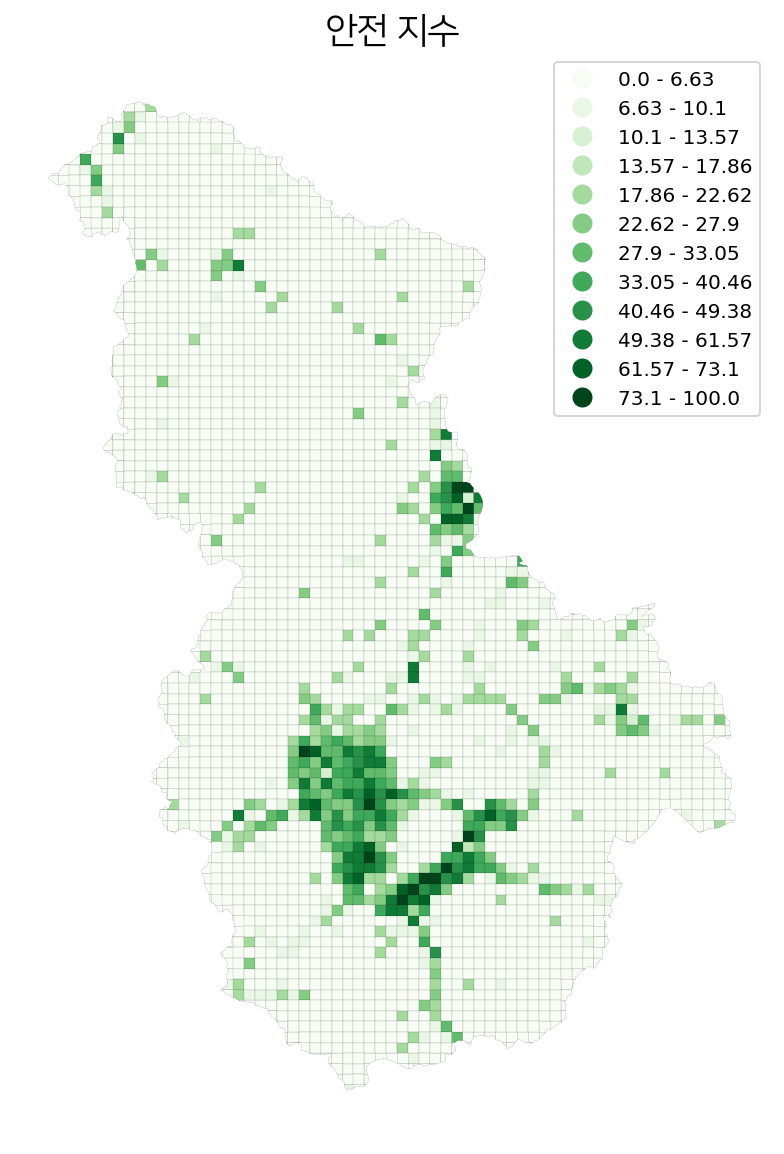

In [162]:
# PCA 결과를 바탕으로 geo(격자) 데이터와 합쳐준다.
pca = pd.merge(safety_rate,geo,on='id',how='outer')
pca = gpd.GeoDataFrame(pca)

plot_grid_map(pca, col = 'PC1', title = '안전 지수', k=12,
              mode = 'cont_classify',c_mode = 'FisherJenks', colors = 'Greens', percen = False)

### 교통 지수

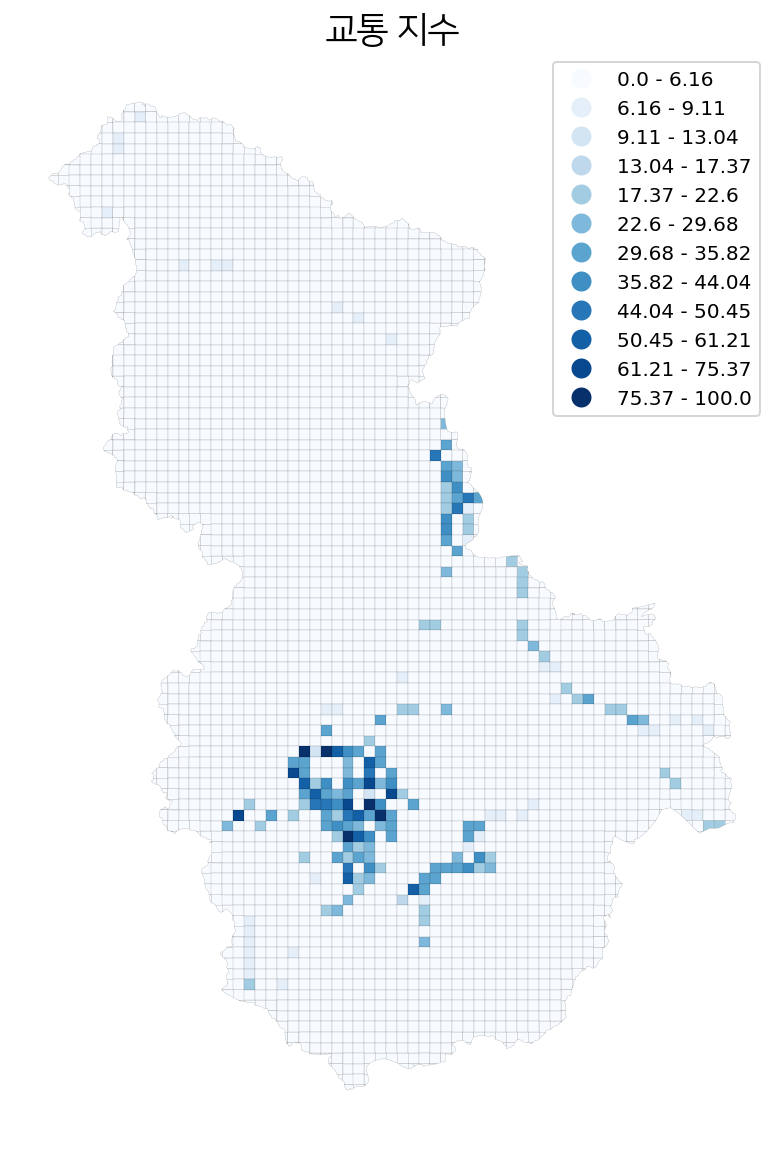

In [163]:
# PCA 결과를 바탕으로 geo(격자) 데이터와 합쳐준다.
pca = pd.merge(transport_rate,geo,on='id',how='outer')
pca = gpd.GeoDataFrame(pca)

plot_grid_map(pca, col = 'PC1', title = '교통 지수', k=12,
              mode = 'cont_classify',c_mode = 'FisherJenks', colors = 'Blues', percen = False)